In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

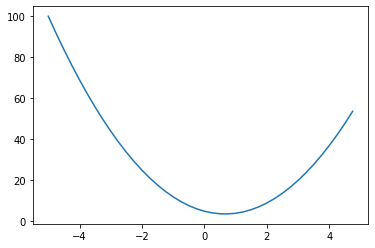

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [13]:
# whats the derivative of f(x) at each point of x
h = 0.001
x = 2/3
(f(x + h) - f(x)) / h # approximation of slope

0.0029999999995311555

In [15]:
# a bit more complex now
a = 2.
b = -3.
c = 10.
d = a*b+c
d

4.0

In [23]:
h = 0.0001

a = 2.
b = -3.
c = 10.

d1 = a*b+c
b += h
d2 = a*b+c

print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2 - d1)/h}')

d1: 4.0
d2: 4.0002
slope: 2.0000000000042206


In [130]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * result.grad
            other.grad = 1.0 * result.grad
        result._backward = _backward
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * result.grad
            other.grad = self.data * result.grad
        result._backward = _backward
        
        return result
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        
        result = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad = (1 - t**2) * result.grad
        result._backward = _backward
        
        return result
    
    def backward(self):
        
        topo =  []
        visited = set()
        
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in topo[::-1]:
            node._backward()
        
        
    
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10., label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [57]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    
    return nodes, edges


def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}", shape="record")
        if n._op:
            op_name = uid + n._op
            dot.node(name=op_name, label = n._op)
            dot.edge(op_name, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

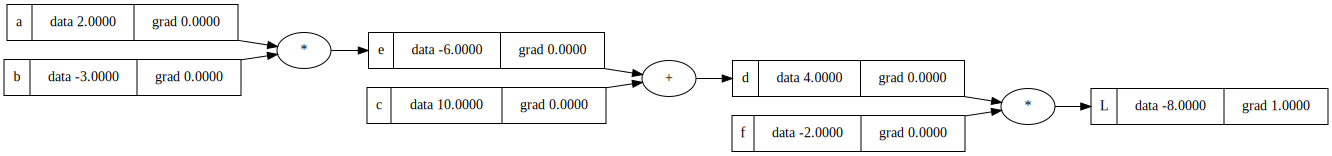

In [59]:
draw_dot(L)

In [69]:
def lol():
    
    h = 0.0001
    
    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'

    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L
    
    a = Value(2. + h, label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'

    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L
    
    print((L2.data - L1.data) / h)
    
lol()

6.000000000021544


```
dl / dc

dd / dc ?
d = c + e

(f(x+h) - f(x)) / h
((c + e) + h - (c + e)) / h
h / h
1


WANT:
dL / dc

KNOW:
dL/dd
dd/dc

CHAIN RULE:
dL / dc = (dL / dd) * (dd / dc)
```
### dL/da
```
dL/da = (dL/de) * (de/da)
e = a*b
((a+h*b) - (a*b)) / h
((a*b) + (h*b) - (a*b)) / h
(h*b)/h
b
```

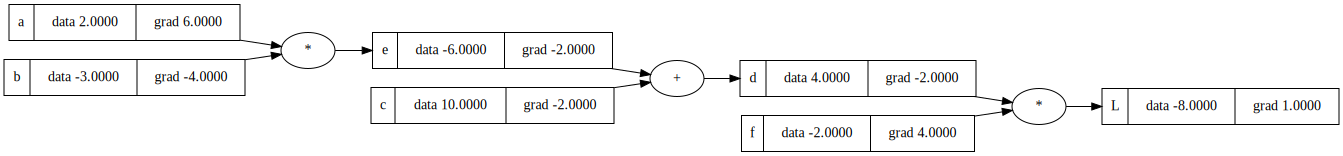

In [71]:
L.grad = 1.
d.grad = -2.
f.grad = 4.
c.grad = -2.
e.grad = -2.
a.grad = 6.
b.grad = -4.
draw_dot(L)

In [72]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
L.data

-7.286496

## Manual Backprop through neuron

In [131]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

In [102]:
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
n.grad = 1 - o.data**2
# plus operator is a distributor of gradient, so b and x1w1x2w2 are jsut 0.5 (n) as well
x1w1x2w2.grad = n.grad
b.grad = n.grad
# same flow for additional add
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# x3 = x2w2
# dx3/dx2 = ((x2+h)*w2 - (x2*w2)) / h
# (x2*w2) + (h * w2) - (x2*w2)) / h
# h * w2 / h
# w2
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad



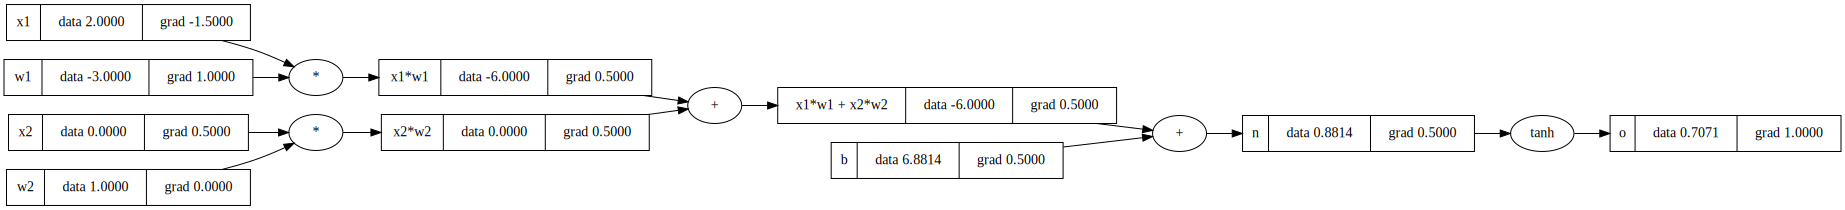

In [132]:
o.backward()
draw_dot(o)